<a href="https://colab.research.google.com/github/JakeANam/AIstudy24/blob/master/LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import matplotlib.pyplot as plt

# 훈련 결과 표시
def plot_for_loss_accuracy(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.xlabel('epoch')
  plt.ylabel('loss, accuracy')
  plt.legend(['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])
  plt.show()

# 훈련 결과 차이 표시
def plot_of_accuracy_difference(history):
  loss_def = []
  accuracy_def = []
  list_idx = 0
  while list_idx < len(history.history['loss']):
    loss_def.append(abs(history.history['loss'][list_idx]-history.history['val_loss'][list_idx]))
    accuracy_def.append(abs(history.history['accuracy'][list_idx]-history.history['val_accuracy'][list_idx]))
    list_idx = list_idx + 1

  plt.xlabel('epoch')
  plt.ylabel('difference')
  plt.legend(['loss_def', 'accuracy_def'])
  plt.show()

In [69]:
from tensorflow import keras
def commit_sequence_test(model, test_seq, test_target):
    testing_model = keras.models.load_model(model)
    testing_model.evaluate(test_seq, test_target)

In [ ]:
# LSTM, GRU cell: 순환 신경망에서 빼 놓을 수 없는 핵심 기술

# SimpleRNN보다 훨씬 복잡하지만 성능이 뛰어나서 순환신경망에 많이 채택된다
# 일반적인 기본 순환층은 긴 sequence를 학습하기 힘들다 - 길 수록 순환되는 은닉 상태에 담긴 정보가 점차 희석된다
# 멀리 떨어져 있는 단어 정보를 인식하는데 어려울 수 있다 -> LSTM, GRU를 사용하는 이유!

# LSTM(Long Short-Term Memory): 단기 기억을 오래 기억하기 위해 고안된 개념
# - 입력과 가중치를 곱하고 절편을 더해 활성 함수를 통과시키는 구조를 여러개 갖고 있다
# - 계산 결과는 다음 timestep에 재사용

# 1. 은닉상태 생성
# - 입력과 이전 timestep의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜서 다음 은닉 상태 생성
# - 이때 기본 순환층과는 다르게 sigmoid함수 사용하고 tanh 함수를 통과한 어떤 값과 곱해져서 은닉 상태로 생성

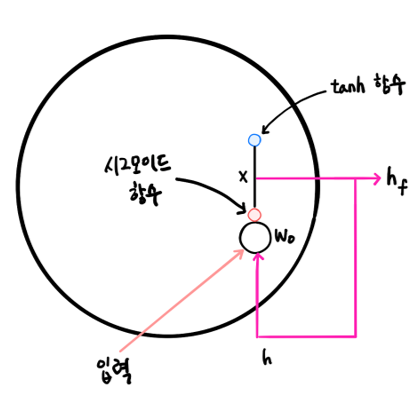

In [1]:
# 위 그림대로 가중치 w_x와 w_h를 통틀어 w_o라고 표시
# 파란색 원은 tanh, 빨간색 원은 sigmoid, x는 곱셈 -> 기본 순환층과 크게 차이 X

# tanh를 통과하는 값? - LSTM에는 순환되는 상태가 2개 (은닉 상태, cell 상태)
# 은닉 상태와 달리 cell 상태는 다음 층으로 전달되지 않고, LSTM cell에서 순환만 되는 값이다

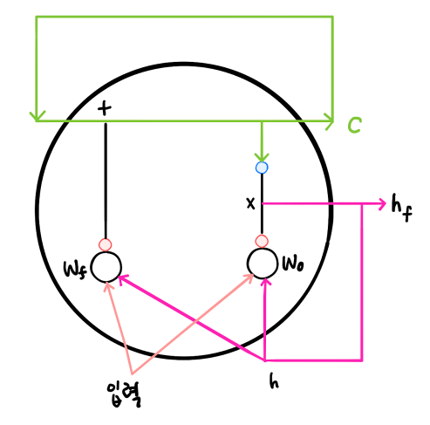

In [2]:
# 위 그림에서 녹색은 순환되는 cell 구조 - cell 상태를 은닉 상태 h와 구분하여 c로 표시

# cell 상태를 계산하는 과정
# 1. 먼저 입력과 은닉 상태를 다시 가중치 w_f에 곱한 다음 sigmoid 함수 통과
# 2. 그 다음 이전 timestep의 cell 상태와 곱해서 새로운 cell의 상태를 만든다
# - 이 cell 상태가 오른쪽에서 tanh 함수를 통과해서 새로운 은닉 상태를 만드는데 기여한다
# 3. LSTM은 마치 작은 cell을 여러개 포함하고 있는 큰 cell
# - 여기서 중요한 것은 입력과 은닉 상태에서 곱해지는 가중치 w_o와 w_f가 다르다는 것
# - 이 두 작은 cell은 각기 다른 기능을 위해 훈련한다

# 여기에 2개의 작은 cell이 더 추가되어 cell의 상태를 만드는데 기여

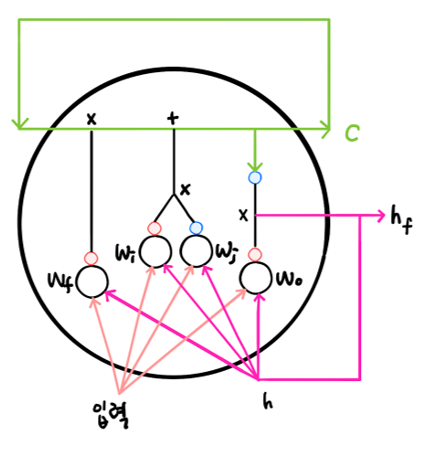

In [3]:
# 위 그림을 보면 이전과 마찬가지로 입려고가 은닉 상태를 각기 다른 가중치에 곱한 다음 하나는 sigmoid를, 다른 하나는 tanh를 통과시킨다
# 그 뒤 두 결과를 곱한 후 이전 cell 상태와 더하는데, 이게 최종 상태의 cell이다 - 상태 기억

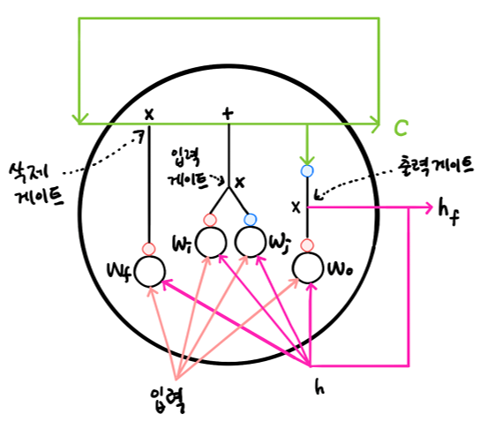

In [4]:
# 위 그림에서 세군데의 곱셈을 각각 삭제 gate, 입력 gate, 출력 gate라고 부른다
# 삭제 gate: cell의 상태에 있는 정보 제거
# 입력 gate: 새로운 정보를 cell 상태에 추가
# 출력 gate: 이 cell 상태가 다음 은닉상태로 출력
# 위의 처리는 keras의 LSTM class가 알아서 돌린다

In [9]:
# keras - imdb test set 준비하기
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
print(train_input.shape, val_input.shape, test_input.shape)

(20000,) (5000,) (25000,)


In [13]:
# token 준비
# - 각 sample길이를 100에 맞추고 부족할 때 padding 추가
# - pad_sequences에 truncating='pre' 생략됨 - 기본 값으로 맨 뒤 기준으로 정렬하고 앞쪽 빈칸은 0
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [15]:
# LSTM cell을 사용한 순환층 생성
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16, input_shape=(100,))) # num_words=500, embedding vector 크기=16, maxlen=100 - 그래서 input_shape=(100,)
model.add(keras.layers.LSTM(8)) # neuron 개수 8개
# neuron개수, vector 크기는 변경해도 좋다. 단, 2진법으로 맞춰서 하자(2, 4, 8, 16, ...)
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# compile하고 훈련 시작
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8223 - loss: 0.3975 - val_accuracy: 0.7956 - val_loss: 0.4384
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8223 - loss: 0.3967 - val_accuracy: 0.7964 - val_loss: 0.4384
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.8222 - loss: 0.3965 - val_accuracy: 0.7954 - val_loss: 0.4385
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.8228 - loss: 0.3962 - val_accuracy: 0.7954 - val_loss: 0.4385


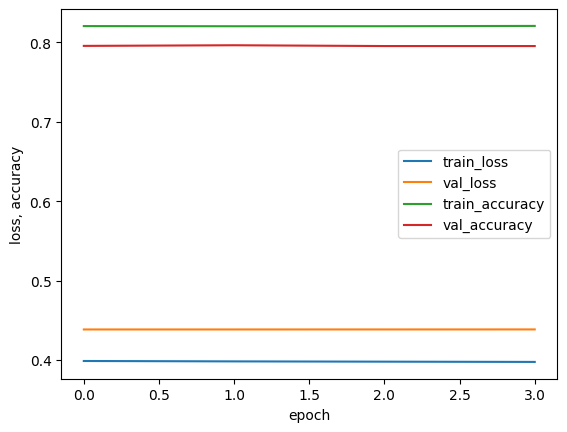

In [32]:
import matplotlib.pyplot as plt

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.xlabel('epoch')
# plt.ylabel('loss, accuracy')
# plt.legend(['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])
# plt.show()

plot_for_loss_accuracy(history)

In [33]:
# 결과를 보니 기본 순환층보다 LSTM이 과대적합을 억제하면서 훈련을 잘 수행하는 것 처럼 보인다
# 다만, 경우에 따라서 과대 적합을 더 강하게 제어할 필요가 있다(dropout 써서)

# 완전 연결 신경망과 합성곱 신경망에서는 dropout을 사용해서 dropout을 적용했었다 - 이 방법으로 model이 훈련set에 너무 과대적합되는 것을 방지

# simpleRNN과 LSTM 모두 dropout 매개변수와 reccurent_dropout 매개 변수를 갖고 있으며
# dropout은 cell의 입력에 적용하고, recurrent_dropout은 순환 은닉 상태에 dropout을 적용한다
# recurrent_dropout을 사용하면 GPU를 사용하기 때문에, model을 훈련하지 못한다(훈련 속도가 대폭 감소) - 그래서 이번에는 dropout만 적용하자

model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model2.add(keras.layers.LSTM(8, dropout=0.3)) # dropout매개값을 0.3으로 해서 30% 입력의 dropout 설정
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# compile하고 훈련 시작
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.5163 - loss: 0.6929 - val_accuracy: 0.5388 - val_loss: 0.6924
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.5516 - loss: 0.6921 - val_accuracy: 0.5584 - val_loss: 0.6915
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.5676 - loss: 0.6910 - val_accuracy: 0.5730 - val_loss: 0.6900
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.5939 - loss: 0.6890 - val_accuracy: 0.5944 - val_loss: 0.6872
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.6084 - loss: 0.6856 - val_accuracy: 0.6144 - val_loss: 0.6818
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.6338 - loss: 0.6786 - val_accuracy: 0.6436 - val_loss: 0.6700
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.6539 - loss: 0.6634 - val_accuracy: 0.6920 - val_loss: 0.6348
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.7006 - loss: 0

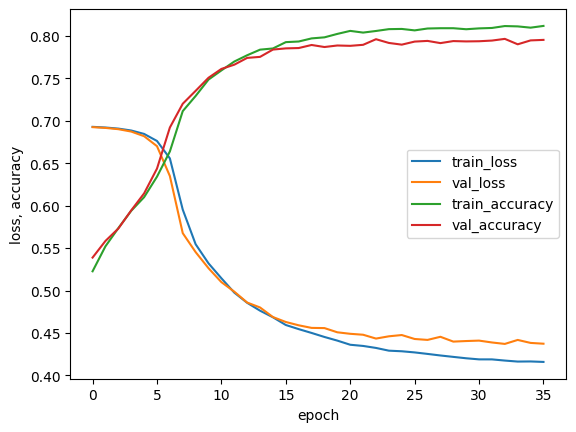

In [35]:
plot_for_loss_accuracy(history)

In [36]:
# 2개 층 연결하기

# 순환층을 연결할 때 한 가지 주의 할 점: 순환층의 은닉상태는 sample의 마지막 timestep에 대한 은닉 상태만 다음 층으로 전달된다

# 하지만 순환층을 쌓게 되면 모든 순환층에 순차 data가 필요하고 앞쪽 순환층이 모든 timestep에 대한 은닉상태를 출력해야 한다
# 오직 마지막 순환층만 마지막 timestep의 은닉 상태를 출력해야 한다

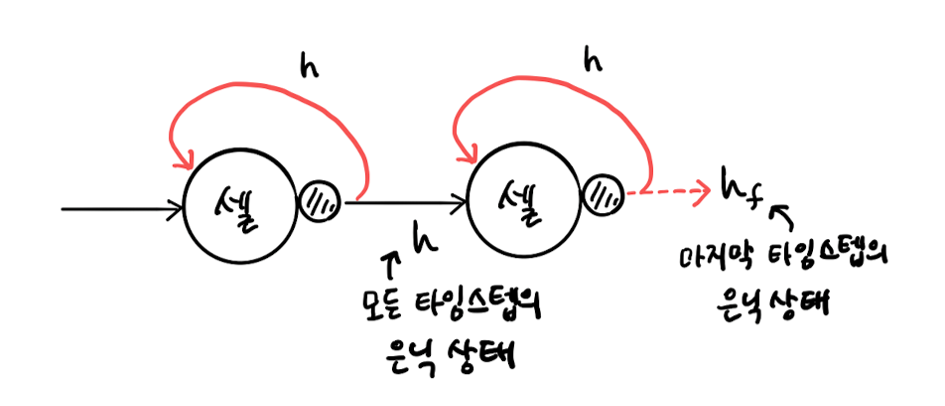

In [37]:
# keras 순환층에서 모든 timestep의 은닉 상태를 출력하려면 마지막을 제외한 다른 모든 순환층에서 return_sequences=true로 지정해야한다

model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True)) # 1번 LSTM
model3.add(keras.layers.LSTM(8, dropout=0.3)) # 2번 LSTM
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 100, 8)              │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.4970 - loss: 0.6932 - val_accuracy: 0.5336 - val_loss: 0.6930
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.5173 - loss: 0.6930 - val_accuracy: 0.5376 - val_loss: 0.6928
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.5351 - loss: 0.6927 - val_accuracy: 0.5712 - val_loss: 0.6924
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.5629 - loss: 0.6921 - val_accuracy: 0.6112 - val_loss: 0.6909
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.5863 - loss: 0.6901 - val_accuracy: 0.6322 - val_loss: 0.6836
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.6249 - loss: 0.6764 - val_accuracy: 0.6824 - val_loss: 0.6309
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.6711 - loss: 0.6236 - val_accuracy: 0.7064 - val_loss: 0.5850
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.7065 - loss: 0

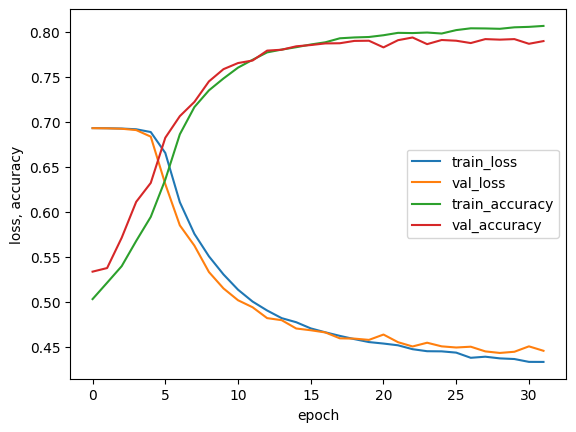

{'accuracy': [0.5030999779701233, 0.5213000178337097, 0.539650022983551, 0.5677499771118164, 0.5944499969482422, 0.6359000205993652, 0.6862499713897705, 0.7164499759674072, 0.7350500226020813, 0.7482500076293945, 0.7602999806404114, 0.7689999938011169, 0.7772499918937683, 0.7803500294685364, 0.7829999923706055, 0.7860000133514404, 0.7884500026702881, 0.792900025844574, 0.7938500046730042, 0.7943500280380249, 0.7962999939918518, 0.7989500164985657, 0.7986999750137329, 0.7993000149726868, 0.7982000112533569, 0.8019999861717224, 0.8040000200271606, 0.803849995136261, 0.8034499883651733, 0.8051000237464905, 0.8055999875068665, 0.8066499829292297], 'loss': [0.6931152939796448, 0.6929495334625244, 0.6926335692405701, 0.6918069124221802, 0.6887320876121521, 0.6655006408691406, 0.6107462644577026, 0.5756089091300964, 0.5506113767623901, 0.5305048227310181, 0.5135361552238464, 0.5003696084022522, 0.4904344379901886, 0.481930673122406, 0.4774012565612793, 0.4705412685871124, 0.4662012755870819, 

In [55]:
plot_for_loss_accuracy(history)
print(len(history.history['loss']))
# plot_of_accuracy_difference(history)

In [39]:
# GRU(Gated Recurrent Units) - LSTM의 간소화
# cell 상태를 계산하지 않고 은닉상태 하나만 포함하고 있다

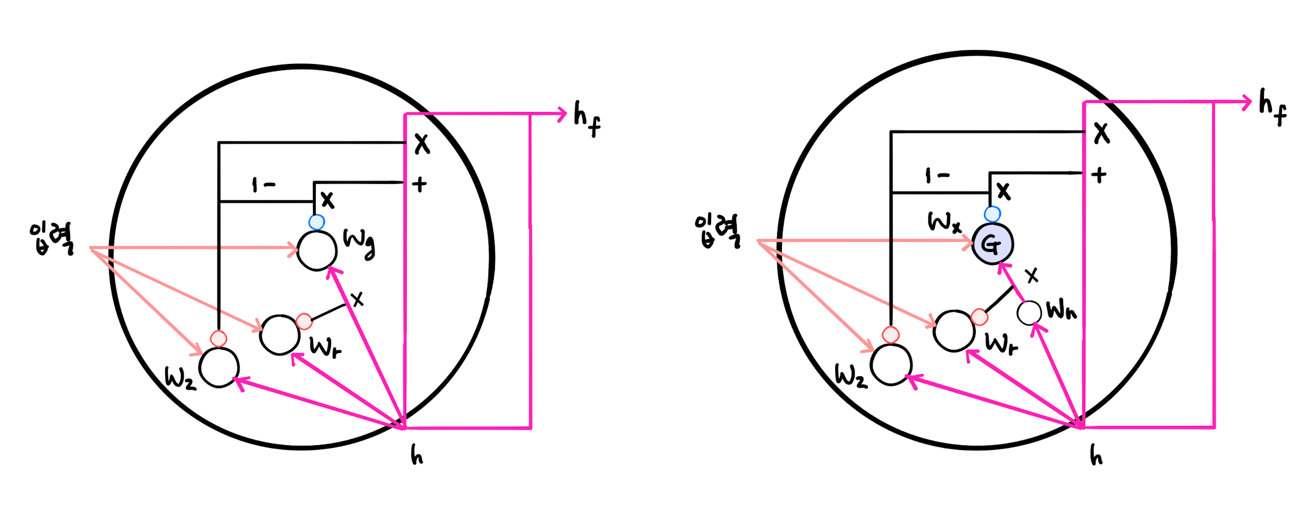

In [41]:
# GRU cell에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 cell이 3개 들어있다
# 2개는 sigmoid 활성화 함수를 사용하고 하나는 tanh활성화 함수를 사용한다
# 여기에도 은닉 상태와 곱해지는 가중치를 합쳐서 나타냈다

# 맨 왼쪽 w_z를 사용하는 cell의 출력이 은닉 상태에서 바로 곱해져 삭제 gate 역할을 수행한다
# 이와 똑같은 출력은 1에서 뺀 다음, 가장 오른쪽 w_g를 사용하는 cell의 출력에 곱한다 - 입력되는 정보를 제어하는 역할
# 가운데 w_r을 사용하는 cell에서는 출력된 w_g cell이 사용할 은닉 상태의 정보 제어

# GRU cell은 LSTM보다 가중치가 적기 때문에 계산량이 적지만 LSTM 못지 않은 좋은 성능을 낸다

In [48]:
# GRU 신경망 훈련하기
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_shape=(100,)))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.summary()
# pharameter를 계산해보면 GRU cell에는 3개의 작은 cell이 있다.
# 작은 cell에는 입력과 은닉 상태에 곱하는 가중치와 절편이 있다.
# 입력에 곱하는 가중치: 16 * 8 = 128개, 은닉 상태에 곱하는 가중치: 8 * 8 = 64
# 절편은 neuron마다 하나씩이므로 8개임, 모두 더하면 128 + 64 + 8 = 200 이런 작은 셀이 3개 이므로 600개

# 624개가 된 이유? - 3개의 절편마다 8개의 neuron까지 존재하기 때문에 3 * 8 = 24 까지 더해졌다
# tensorflow가 이런 계산 방식을 사용하는 이유? - GPU를 잘 활용하기 위해서 (LSTM 개선점)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 8)                   │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.5033 - loss: 0.6932 - val_accuracy: 0.5402 - val_loss: 0.6917
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.5491 - loss: 0.6912 - val_accuracy: 0.5682 - val_loss: 0.6896
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.5755 - loss: 0.6885 - val_accuracy: 0.5912 - val_loss: 0.6863
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.6003 - loss: 0.6845 - val_accuracy: 0.6062 - val_loss: 0.6814
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.6167 - loss: 0.6785 - val_accuracy: 0.6174 - val_loss: 0.6738
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.6317 - loss: 0.6693 - val_accuracy: 0.6336 - val_loss: 0.6619
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.6467 - loss: 0.6546 - val_accuracy: 0.6548 - val_loss: 0.6421
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.6700 - loss: 0

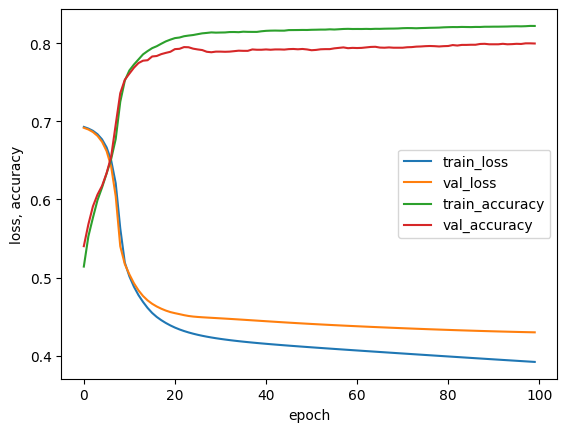

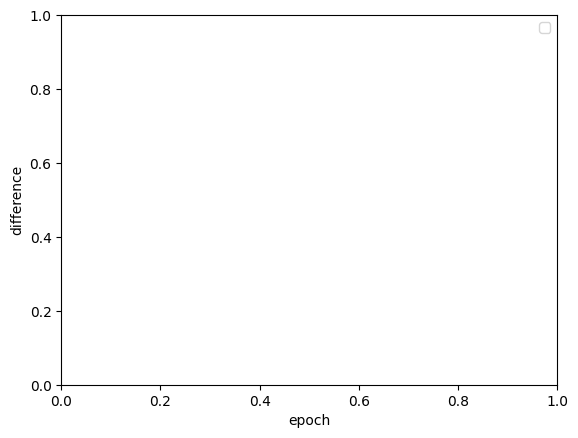

In [62]:
plot_for_loss_accuracy(history)
plot_of_accuracy_difference(history)

In [63]:
# 이제 testset도 전처리해서 해보자
test_seq = pad_sequences(test_input, maxlen=100)

In [70]:
# lstm-model
keras.models.load_models('best-lstm-models.keras', test_seq, test_target)

AttributeError: module 'keras.api.models' has no attribute 'load_models'